In [1]:
import pandas as pd
import numpy as np

In [4]:
%%time
data = pd.read_parquet("C:\\Users\\Mengxiao.Wu\\Desktop\\train\\train_low_mem.parquet")
data.describe()

Wall time: 1min 1s


,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109159e-02,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02,-5.416438e-03,-3.034008e-03,1.934330e-03,...,1.256709e-02,9.002053e-04,-6.509154e-03,2.851608e-03,-4.730820e-03,-2.773806e-02,-1.517383e-03,-7.057928e-03,-4.216896e-03,-4.319488e-03
std,3.560434e+02,1.083616e+03,9.176629e-01,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01,9.895188e-01,1.104578e+00,1.067755e+00,...,1.084496e+00,1.114387e+00,1.070176e+00,1.101158e+00,1.144516e+00,9.592550e-01,1.140459e+00,1.108097e+00,1.051252e+00,1.008220e+00
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


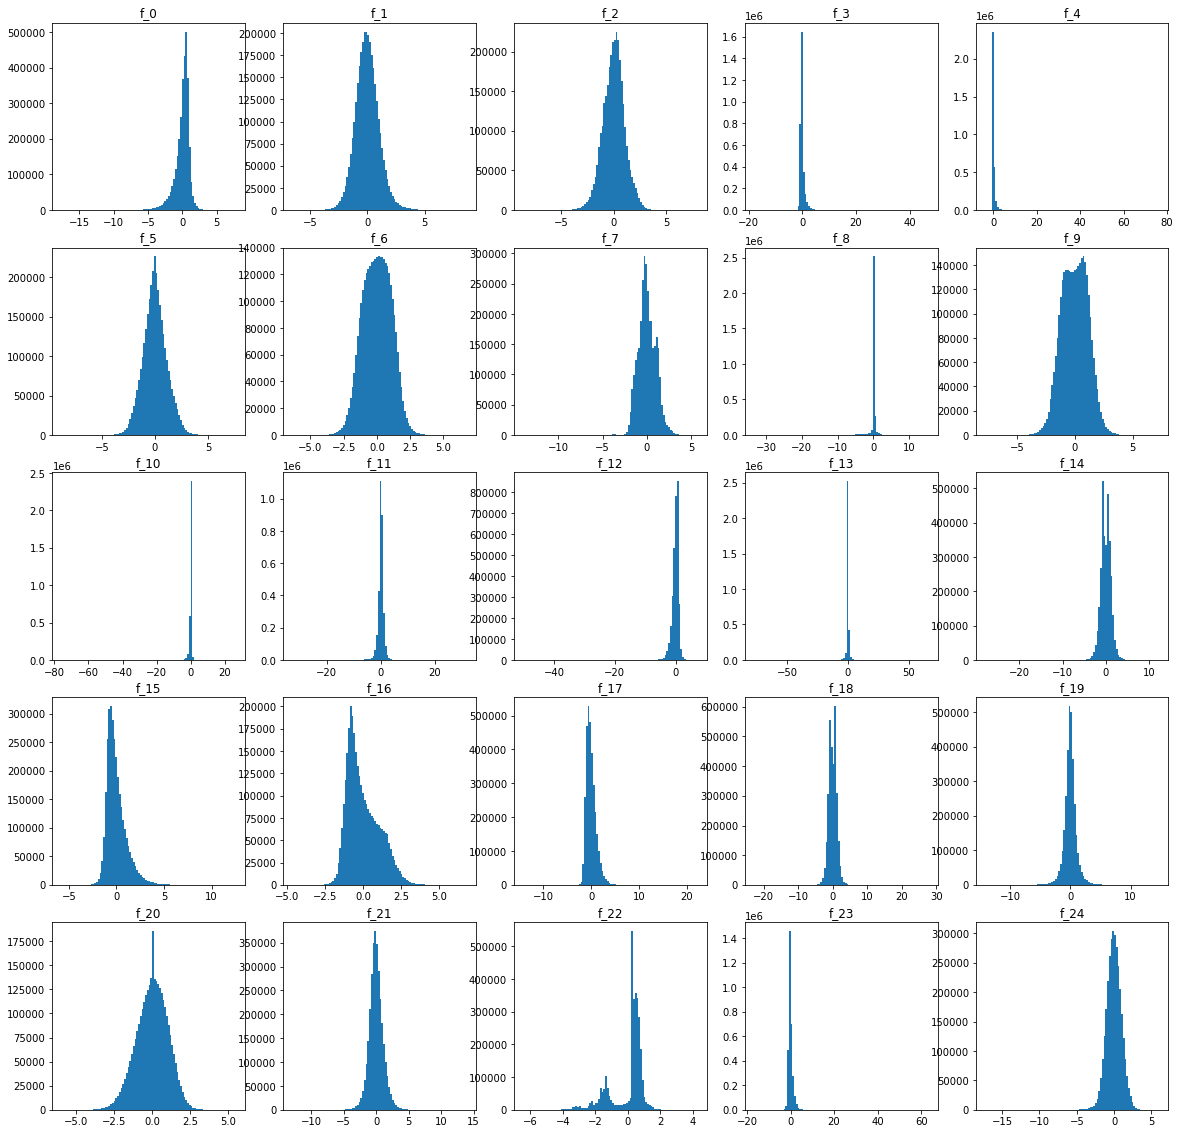

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,20))
for i in range(25) :
    plt.subplot(5, 5, i+1)
    plt.hist(data[f"f_{i}"], bins=100)
    plt.title(f"f_{i}")
plt.show()

In [17]:
outlier_list = []
outlier_col = []
z = data.drop(['row_id', 'time_id', 'target', 'investment_id'],axis = 1)
feature_cols = z.columns.unique()

for col in feature_cols :
    temp_df = z[(z[col] > z[col].mean() + z[col].std() * 50) |
                       (z[col] < z[col].mean() - z[col].std() * 50) ]
    print(temp_df)
    temp2_df = z[(z[col] > z[col].mean() + z[col].std() * 25) |
                        (z[col] < z[col].mean() - z[col].std() * 25) ]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) < 20  :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
# print(len(outlier_col), len(outlier_list))

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

              f_0       f_1       f_2        f_3       f_4       f_5  \
2017395 -0.148269 -0.242992 -2.250082   8.408795  0.274163  0.971946   
2021531 -1.699914  1.123457 -1.949654  16.747000  0.333325 -1.937521   
2236468  0.000000  2.646606 -2.067358  17.366192  1.173460 -1.898638   
2271411  0.668391  4.015158 -2.221444  19.221195  0.285468 -0.725526   
2277671  0.649978  3.632953 -2.176117  17.218410  0.200197  1.455099   
2472345  0.786365  1.629461 -2.583622  17.212275  0.148646  0.600875   
2478542  0.468351  1.536045 -2.201186  17.877594  0.121228 -1.554767   
2619786 -0.647990  0.798382 -1.797712  12.024286  0.338120  3.622653   
2695770  0.755638  1.652058 -1.528809  14.604204  2.482347 -1.541660   
2698936  0.902743  0.679067 -2.886719  14.374614  2.105941 -0.122642   
2702083  0.588642  0.122928 -3.478514  14.599245  1.706957  3.348218   
2704787  0.698886  1.151417 -3.253100  18.824612  1.303068  0.286886   
2707091  0.333917  0.154806 -5.717827  15.725054  1.351071 -1.80

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
f_12 14
              f_0       f_1       f_2        f_3        f_4       f_5  \
2576647  0.805688 -1.983739 -0.908393  -0.402712   3.842429  2.169950   
2595451 -0.645097 -1.327127 -1.489345  -0.485901   5.203355 -0.980381   
2623753  1.184979 -0.939545 -0.699968  -1.038104   4.026818  2.368494   
2783415  0.345723  2.123711 -0.064099  22.726

              f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
3054288 -0.816390  3.071889  5.256477 -0.538971 -0.320161  1.884128  0.714078   
3071281  0.481355  1.922900  5.713894 -0.440929 -0.274010 -1.644084 -2.788444   
3084889 -0.436810  1.292834  4.641576 -0.833342 -0.227664 -0.516570 -0.360139   
3088301  0.607771  0.629434  4.335372 -0.859459 -0.167914 -1.885629 -1.254100   
3091732 -1.767501  0.548519  5.630184 -0.857742 -0.205504 -1.638089 -1.543918   
3102030 -0.011715  2.231408  4.313098 -0.359861 -0.293067 -0.213765 -1.551048   
3105465 -1.325929  2.731430  4.416136 -0.341104 -0.274085  0.616415  0.251970   

              f_7       f_8       f_9  ...     f_290     f_291     f_292  \
3054288  2.376833  1.379044  0.816325  ...  3.216929  1.598978  0.308572   
3071281  1.835832  0.606106  1.050148  ...  2.861915 -0.156485  7.063092   
3084889  1.541844  1.015782  0.871944  ... -2.282644 -0.951564  5.035217   
3088301  1.010618 -0.915331  0.901139  ... -2.5

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

              f_0       f_1       f_2        f_3       f_4       f_5  \
2486421 -0.082264  3.653584 -2.507639  31.284510  0.775574  2.386364   
2492646  0.447588  2.246997 -2.537095  31.266666  0.848051  0.843726   

              f_6       f_7       f_8       f_9  ...     f_290     f_291  \
2486421 -0.794302 -1.007360 -1.451076  2.107189  ... -0.341468 -0.842392   
2492646 -0.925874 -1.204608 -1.778505  0.960956  ...  0.858001 -0.703641   

            f_292     f_293     f_294     f_295     f_296    f_297     f_298  \
2486421  1.086224  0.112485  0.952804  6.780950  1.409538 -0.07712  0.000090   
2492646  4.526604 -0.112092  1.178017  6.134496 -1.105662 -2.42778 -0.000115   

            f_299  
2486421  7.630541  
2492646  6.067062  

[2 rows x 300 columns]
f_54 2
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_

f_64 5
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

              f_0       f_1       f_2        f_3       f_4       f_5  \
1347988 -0.240522  1.740733 -1.612998  11.192829  4.158724  2.076635   
1350516 -0.807477  1.741523 -1.692245  10.948584  3.837616  2.239437   
1391274 -0.214044 -3.022694  1.126324   7.326730  4.697852 -0.355196   
1628723 -0.094267  2.072485 -3.160947  19.594603  0.563163 -0.128419   
1936196  0.029839 -1.196221  1.358142   0.130610  1.261494  0.864216   
...           ...       ...       ...        ...       ...       ...   
2975016  0.811058 -2.391164  0.387420   4.148539 -0.015209 -0.641251   
2978305  0.493147 -1.820175  0.173150   6.413799 -0.060336 -0.250155   
3025099  1.278743 -1.119363 -1.540354  21.156857  0.320369  2.205198   
3035118  0.578803 -1.089155 -0.391984   8.973705  0.492228 -2.365288   
3038442  0.932096 -0.663430 -0.334714   9.505837  0.455883 -1.994008   

              f_6       f_7       f_8       f_9  ...     f_290     f_291  \
1347988 -2.068657  1.181314 -4.913789  1.045751  ... -0.630

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

             f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
200709 -0.123542 -0.858213 -1.352015  1.410089 -0.763096 -2.333614  1.439174   

             f_7        f_8       f_9  ...     f_290     f_291     f_292  \
200709 -0.306846 -12.795321 -1.367603  ... -3.903148 -0.396567 -0.155047   

           f_293     f_294     f_295     f_296     f_297    f_298     f_299  
200709 -4.459338  1.050656  0.179114  0.488256  2.443189 -0.22326 -0.887231  

[1 rows x 300 columns]
f_153 1
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
              f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
248486  -0.096219  3.108389 -0.049133 -0.592499 -0.550361  2.278027 -2.309674   
1865322  0.000000  3.900254  0.256176 -0.295231  0.025260  2.844385 -1.693662   
2025827 -0.598243  3.262373 -1.601865  0.397844  0.065796  3.664814 -0.948499   
2068901 -0.160382  3.

f_172 41
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
f_173 3
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, 

[32 rows x 300 columns]
f_175 32
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
              f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
2480193  0.659993  4.697025 -2.234583  19.54562  0.686174  1.626743 -1.248436   

              f_7       f_8       f_9  ...     f_290     f_291      f_292  \
2480193 -1.436037 -0.756205  3.284608  ... -1.574037 -1.590664  12.846649   

            f_293     f_294

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
f_196 2
              f_0       f_1       f_2        f_3       f_4       f_5  \
2477085 -4.049635  4.989459 -2.366604  11.282644  0.994139  2.272369   

              f_6       f_7       f_8       f_9  ...     f_290     f_291  \
2477085 -2.175489 -1.279348 -1.291356  2.895491  ... -0.609902 -1.171673   

             f_292    f_293     f_294  

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
              f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
1418648 -1.387326  3.308428 -1.022329 -0.416598 -0.033391  2.199745 -4.731685   
1601292 -3.345269  4.021305  1.075199 -0.363681  1.588747  0.833303 -3.576758   
2020369 -0.754754  0.554581 -0.825327  2.662383  0.927136  0.942246 -0.778533   
2283671 -3.808741  4.

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

f_271 15
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54, f_55, f_56, f_57, f_58, f_59, f_60, f_61, f_62, f_63, f_64, f_65, f_66, f_67, f_68, f_69, f_70, f_71, f_72, f_73, f_74, f_75, f_76, f_77, f_78, f_79, f_80, f_81, f_82, f_83, f_84, f_85, f_86, f_87, f_88, f_89, f_90, f_91, f_92, f_93, f_94, f_95, f_96, f_97, f_98, f_99, ...]
Index: []

[0 rows x 300 columns]
Empty DataFrame
Columns: [f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_13, f_14, f_15, f_16, f_17, f_18, f_19, f_20, f_21, f_22, f_23, f_24, f_25, f_26, f_27, f_28, f_29, f_30, f_31, f_32, f_33, f_34, f_35, f_36, f_37, f_38, f_39, f_40, f_41, f_42, f_43, f_44, f_45, f_46, f_47, f_48, f_49, f_50, f_51, f_52, f_53, f_54,

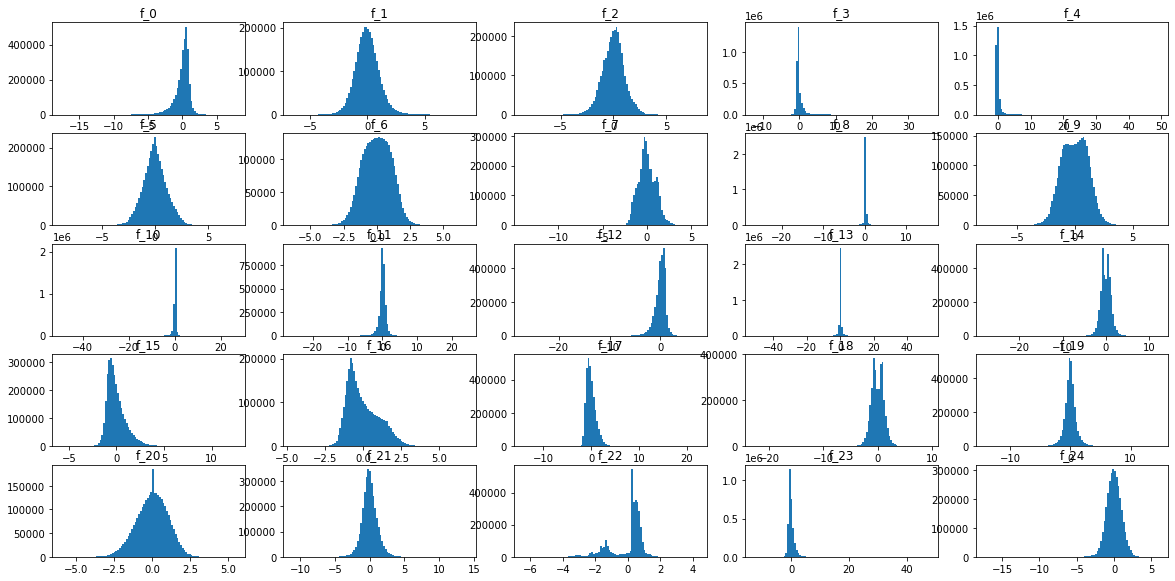

In [7]:
z.drop(z.index[outlier_list], inplace = True)

plt.figure(figsize=(20,20))
for i in range(25) :
    plt.subplot(10, 5, i+1)
    plt.hist(z[f"f_{i}"], bins=100)
    plt.title(f"f_{i}")
plt.show()

In [8]:
#归一化Z z-score
def Normalize(raw_list):
    np_data=np.array(raw_list)
    length=len(raw_list)
    #列均值
    means=np.mean(np_data,axis=0)
    #列标准差
    sigmas=np.std(np_data,axis=0)
    #z-score转化成矩阵运算
    mean_matrix=np.tile(means,(length,1))
    sigma_matrix=np.tile(sigmas,(length,1))
    np_data=(np_data-mean_matrix)/sigma_matrix

    return np_data

Normalize(z)

array([[ 0.86113757,  0.12258879, -0.3982511 , ..., -0.9355391 ,
        -0.26936692,  0.33112845],
       [ 0.74849105, -0.48574623,  0.71144116, ..., -0.8315952 ,
        -0.92182577, -0.34129933],
       [ 0.36289644,  0.6092568 ,  0.54219896, ..., -0.54571825,
        -0.10430577,  0.25232187],
       ...,
       [ 0.9045382 , -1.0636247 ,  0.96798867, ..., -0.06491129,
        -1.4978743 , -0.2948006 ],
       [-2.3746638 ,  0.32279077,  0.06596336, ..., -0.8714726 ,
         0.5824989 , -0.37002438],
       [-0.08440273,  0.19675301, -0.53984946, ..., -0.5014404 ,
         0.64042014,  0.46742955]], dtype=float32)

In [9]:
z.describe()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,...,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06,3.140461e+06
mean,1.682172e-03,-1.282066e-02,8.563815e-03,-2.105837e-02,-8.704447e-03,-3.086328e-03,2.048268e-03,5.910077e-03,1.338979e-02,-3.247420e-03,...,1.262724e-02,9.499782e-04,-6.686928e-03,2.959660e-03,-4.793485e-03,-2.874619e-02,-1.506290e-03,-7.104652e-03,-4.203258e-03,-5.997960e-03
std,1.079625e+00,1.030548e+00,1.029929e+00,9.470567e-01,8.963277e-01,1.104468e+00,1.067613e+00,1.004455e+00,1.069596e+00,1.145284e+00,...,1.084137e+00,1.114324e+00,1.069537e+00,1.100851e+00,1.144525e+00,9.537563e-01,1.140431e+00,1.107876e+00,1.051044e+00,9.873697e-01
min,-1.765789e+01,-6.579473e+00,-8.572386e+00,-1.240608e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,-1.394807e+01,-2.668865e+01,-7.782067e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,-4.071021e-01,-6.813878e-01,-6.529455e-01,-4.496085e-01,-3.532385e-01,-7.070839e-01,-7.910036e-01,-6.300643e-01,1.064481e-01,-8.624554e-01,...,-6.037059e-01,-8.355157e-01,-6.981152e-01,-1.375373e-01,-9.397985e-01,-5.148028e-01,-9.573807e-01,-7.239050e-01,-8.164942e-01,-5.079949e-01
50%,2.431442e-01,-4.883718e-02,4.353122e-02,-2.640125e-01,-1.909103e-01,-2.146631e-02,1.446166e-02,-5.882107e-02,1.590251e-01,1.505170e-02,...,6.086323e-02,-2.021240e-01,-1.910563e-01,2.164071e-01,2.087202e-01,-2.908437e-01,6.955573e-03,-1.650357e-01,2.309632e-02,-2.824405e-01
75%,6.649478e-01,6.085248e-01,6.586535e-01,7.747962e-02,2.770642e-02,6.834627e-01,8.008521e-01,6.882808e-01,2.333343e-01,8.510516e-01,...,6.881666e-01,9.036535e-01,4.840021e-01,5.088849e-01,8.614854e-01,1.272987e-01,9.503851e-01,6.097050e-01,7.984666e-01,1.409201e-01
max,7.845261e+00,8.707207e+00,8.009340e+00,3.560914e+01,4.946459e+01,7.646200e+00,6.778142e+00,5.721995e+00,1.549887e+01,7.320475e+00,...,9.298274e+00,9.725060e+00,1.847994e+01,6.587691e+00,6.978151e+00,2.000986e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.270977e+01


In [11]:
z.shape

(3140461, 300)

In [12]:
data

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,1219_3768,1219,3768,0.033600,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,1219_3769,1219,3769,-0.223264,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,1219_3770,1219,3770,-0.559415,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,1219_3772,1219,3772,0.009599,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


In [13]:
z['row_id'] = data['row_id']
z['time_id'] = data['time_id']
z['investment_id'] = data['investment_id']
z['target'] = data['target']

In [16]:
z.to_hdf("C:\\Users\\Mengxiao.Wu\\Desktop\\train\\winsorize.h5", "train")